In [54]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.externals import joblib
from sklearn.decomposition import PCA

In [2]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [281]:
file = 'DataForMLLive.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History')

In [282]:
col_names= ['Created Time', 'Biker Assigned Time', 'Delivered Time']
df.dropna(subset=col_names, how='any', inplace = True)
df.shape

(51837, 11)

In [283]:
timestamp_info = pd.DataFrame(columns=['Created Time', 'Biker Assigned Time'])
timestamp_info[col_names] = df[col_names].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
info_taken = pd.DataFrame()
info_taken['Hours2assign']= df.apply(get_time,c1='Created Time', c2='Biker Assigned Time', axis=1)
#info_taken['Hours2accept']= df.apply(get_time,c1='Biker Assigned Time', c2='Biker Accepted Time', axis=1)
info_taken['Hours2deliver']= df.apply(get_time, c1='Biker Assigned Time', c2='Delivered Time', axis=1)
info_taken['BikerID'], levels = pd.factorize(df['Biker'])
info_taken['LocationCode']= df['Location Code']
info_taken['Pending Order By Biker'] = df['Pending Order By Biker']
info_taken['Pending Orders Location Wise']= df['Pending Orders Location Wise'] 

In [284]:
info_taken.shape

(51837, 6)

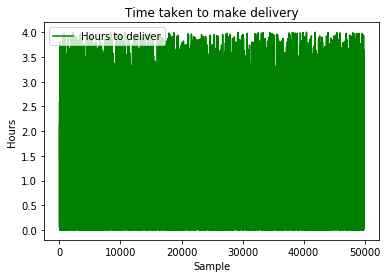

(49848,)

In [285]:
rm_grtr_4 =  info_taken['Hours2deliver'] > 4
info_taken = info_taken[~rm_grtr_4]
rm_neg = info_taken['Hours2deliver'] < 0
info_taken= info_taken[~rm_neg]
plt.plot(info_taken['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()
plt.show()
rm_neg.shape

In [320]:
df = df [~rm_grtr_4]
df = df[~rm_neg]
timestamp_info = df[['Created Time', 'Biker Assigned Time']].values.astype(int)
location_code = info_taken[['BikerID']].values
X = np.concatenate((timestamp_info, location_code), axis=1)
#X= info_taken[['BikerID', 'Hours2assign']].values #, 
Y= np.reshape(info_taken['Hours2deliver'].values, -1)

/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/expertsvision/Desktop/GA_implemented_with_flask/server/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [321]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.3)

In [169]:
tree_regression_model = tree.DecisionTreeRegressor()
trained_model = tree_regression_model.fit(X_trn, Y_trn)

In [322]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(2, 20), 'min_samples_split':np.arange(15, 31)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=5, n_jobs=6, scoring=scoring, verbose=1)

In [323]:
grid_search.fit(X_trn,Y_trn)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=6)]: Done 168 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 869 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done 1119 tasks      | elapsed:   33.9s
[Parallel(n_jobs=6)]: Done 1440 out of 1440 | elapsed:   53.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]), 'min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [324]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'max_depth': 19, 'min_samples_split': 17}
[0.32665087 0.44908544 0.22426369]


In [325]:
#predict_model = trained_model.predict(X_tst)
predict_model = grid_search.best_estimator_.predict(X_tst)

In [326]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model)
print(mse)

r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.3299548658827647
0.3970886240231388


0.3969676384627422

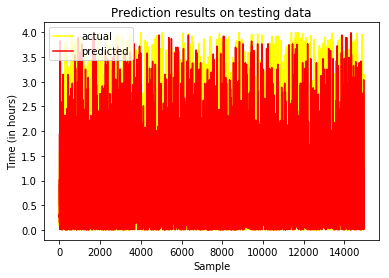

In [327]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()